# Locally running portfolio-analysis streamlit app

## Modifications to make it a streamlit app

The first thing we will need to do is to slightly modify our app to transform it into a streamlit app as we previously did for our Two Agent Stand Up Comedy app. This process is quite straightforward, these are the modification we will need to do:

1. Import streamlit at the beginning of the script:
```python
import streamlit as st
```
2. Ask the user to write the tickers they'd like to analyze in a text field and add a button that will trigger the app:
```python
assets = st.text_input("Assets you want to analyze (provide the tickers)?")
hit_button = st.button('Start analysis')
```
3. Replace a string variable called `assets` in the `financial_tasks` prompt with tickers provided in the text field once the user hits the button:
```python
if hit_button is True:

    financial_tasks = [
    f"""Today is the {date_str}. 
    What are the current stock prices of {stocks}, and how is the performance over the past 6 months in terms of percentage change? 
    Start by retrieving the full name of each stock and use it for all future requests.
    Prepare a figure of the normalized price of these stocks and save it to a file named normalized_prices.png. Include information about, if applicable: 
    * P/E ratio
    * Forward P/E
    * Dividends
    * Price to book
    * Debt/Eq
    * ROE
    * Analyze the correlation between the stocks
    Do not use a solution that requires an API key.
    If some of the data does not makes sense, such as a price of 0, change the query and re-try.""",

    """Investigate possible reasons of the stock performance leveraging market news headlines from Bing News or Google Search. Retrieve news headlines using python and return them. Use the full name stocks to retrieve headlines. Retrieve at least 10 headlines per stock. Do not use a solution that requires an API key. Do not perform a sentiment analysis.""",
]
```
4. We will also add a spinner that will let the user know that the chat is ongoing:
```python
    with st.spinner("Agents working on the analysis...."):
        chat_results = autogen.initiate_chats(
            
        ... # main chat flow
            
        )
```
5. At the very end of the code, once the agents have finished chatting, we will present the results. We will show the image that was generated and will present the markdown blogpost by choosing the last message in the chat conversation:
```python
    st.image("./coding/normalized_prices.png")
    st.markdown(chat_results[-1].chat_history[-1]["content"])
```
6. Since we mainly want to show the blogpost on the streamlit webpage, we are going to remoev the last chat that aimed at exporting the blogpost in a `.md` file. We can thus also delete the Export agent definition.

## Run the streamlit portfolio-analysis app locally

You should now be able to run this streamlit app locally using the command:

`streamlit run P02-S06-02-Streamlit-financial_report.py`

Try it and ensure everything is working as planned!


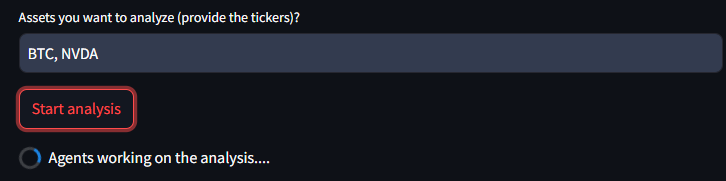
---


# Deploy and Run your app in the cloud

## Create your Google Cloud account

1. Go to https://cloud.google.com/shell
2. Click "Start Free"
3. Provide requested information, CC info is required but won't be billed during free trial (3 months - $300)

### Set an project account name

Let's call it: `portfolio-analysis`

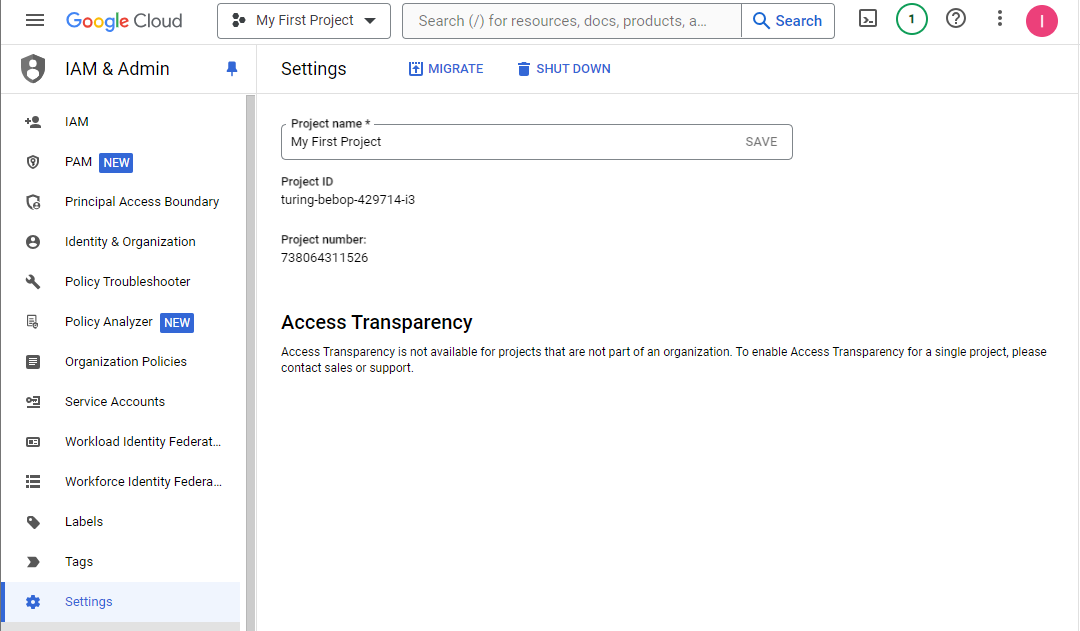

---

## Run your app on an ephemeral machine for testing

### Cloud Shell Editor

* Search for and go to the Cloud Shell Editor  
The interface is very similar to VSCode.

#### portfolio-analysis app code

* Create a folder in your `home` folder called `portfolio-analysis`
* Create a new file inside of it called `app.py`
* Copy-paste the portfolio analysis streamlit app code in it

#### requirements.txt

* Create a `requirements.txt` file in that folder
* List in it all the requirements of our app. In this case, our requirements will be:
```
streamlit
pyautogen
```

### Running an app from your Cloud Shell machine

Let's see if we can run our app from a Virtual Machine provided by Google. This is the first step to then deploy it on a permanent independant machine.

#### Create a virtual environment

* Click `Open Terminal`  
Let's create a virtual environment in the `portfolio-analysis` folder.

* First, enter the `portfolio-analysis` folder with:

```
cd portfolio-analysis/
```

* Then, create a virtual environment with:

```
python3 -m venv .env
```
It should take a few seconds, it'll be over after that. You can checkl that it worked by using `ls -la`, it should show that a folder called `.env` exists.  

Your terminal should look like this after these steps:
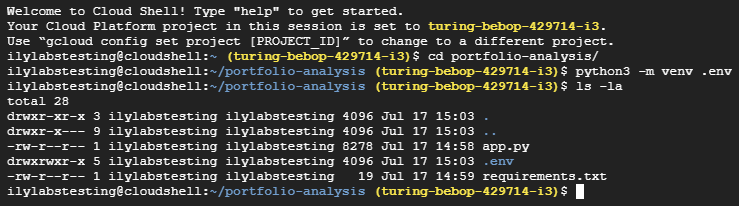

* Let's now load the virtual environment we just created:
```
source .env/bin/activate
```
You should notice a `(.env)` at the beginning of your terminal prompt, as you should now know, that means that we are indeed in the virtual environment.

#### Install dependencies

* Let's now install all our python packages dependencies in this virtual environment using the `requirements.txt` file:
```
pip install -r requirements.txt
```
You will see all the installation steps progressing. Once it is over, we are ready to try running our app!

### Run the app from Cloud Shell machine

We will now run the streamlit `app.py` as we previously did on our local machine, but because it will this time be running on a Google Cloud machine, we will have to use a slightly modified command to do so:
```
streamlit run app.py --browser.serverAddress=localhost --server.enableCORS=false --server.port 8080
```

- `streamlit run app.py`: This is the main command that tells Streamlit to run your application which is in the `app.py` file.

- `--browser.serverAddress=localhost`: This option sets the server address to `localhost`. This means your application will run on the Google provided local machine, we need to specify this this time.

- `--server.enableCORS=false`: CORS stands for Cross-Origin Resource Sharing. It's a security feature that restricts how resources on a web page can be requested from another domain outside the domain from which the first resource was served. By setting `enableCORS` to `false`, you're telling Streamlit to disable this feature. This is again necessary because our application needs to access resources from different domains on the Google machine.

- `--server.port 8080`: This option tells Streamlit to run the application on port 8080. It's again necessary because of how Google will run our application.

Run the command and click on the link that will appear in the terminal!

You should now be on our Streamlit app! Congrats! :tada:  

Try running it to see if everything works well, **you an track its evolution in the Terminal**. Don't forget that the first time you'll run it, the agents will most likely need to install python packages (matplotlib, pandas, yfinance, ...) in your virtual environment which will take some time. 

Now that we have validated that our app works on a Google machine, we can move on to deploying it with more permanence. 

---

## Deploy the app on a persistent machine

### Add a Dockerfile

Before deploying our app, we will need to add a `Dockerfile`. A Dockerfile is a text file that contains a set of instructions used to create a Docker image, a Docker image is a small virtual machine that is designed for a specific purpose. These instructions include:  
the identification of an existing Docker image, in our case, we will be using a minimalist `python 3.9` image, to be used as a base;  
commands to be run during the image creation process, putting our app in a specific folder and installing our python packages;  
commands that should be run each time the machine boots, in our case that will be runnig our streamlit app;  
and a description of the ports that the container will listen on so that we can access the streamlit app.

* Create a file named `Dockerfile` in your app's folder
* Put the following content inside of it:
```dockerfile
FROM python:3.9-slim

# Expose Port
EXPOSE 8080

# Copy Files
COPY . /app

# Set Working Directory
WORKDIR /app

# Install Dependencies
RUN pip install -r requirements.txt

# Run Streamlit App
CMD ["streamlit", "run", "app.py", "--server.port=8080", "--server.enableCORS", "false"]
```

This file will be used as a guide during the creation of your container. Your container will be a standalone Virtual Machine that will constantly be running your app.

### Deploy a container on Google' servers

To deploy your app, start by using the following command in the terminal from the `portfolio-analysis` folder:
```
gcloud run deploy portfolio-analysis --source .
```

* Click `Authorize`.
* Answer `y` when prompted to enable APIs.
* Choose a server that is geographically close to you or to the location most users will use your app from.
* Accept the creation of a container on that server for you by inputing `Y`.
* Allow unauthenticated invocations so anyone can use your app: `y`.
* Wait for the container deployment...
    * Once the `Building container` step is reached, you can click on the link shown to follow the deployment of your container. It is possible to track and see the container being built piece by piece, the python packages in your `requirements.txt` being installed, etc...
* Once the deployment over, you should be provided with a link that will allow you to reach your app! Follow it to try the app and check that everything is working well (you can also find this URL in a convenient place later).

## Monitor your container: Cloud Run

Your app is now running on a persistent Google Cloud machine. You can monitor the machine by going to the "Cloud Run" section of Google Cloud:

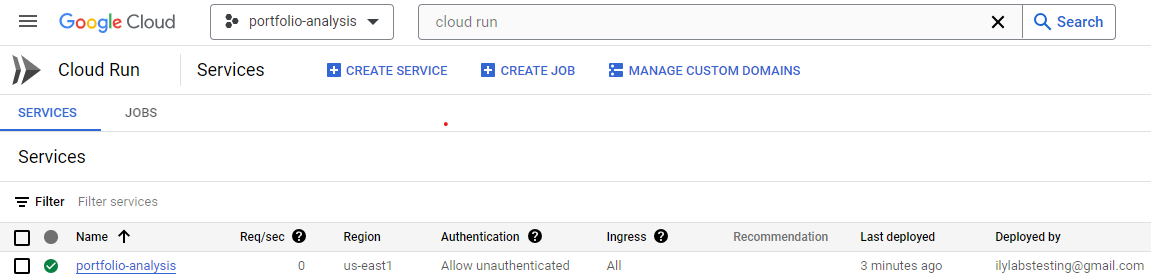

Click on your machine to enter its monitoring. 

* First important thing here is the URL written at the top which will allow you to load your app
* Second important point is the "LOGS" tab, by going there, we can monitor the logs of our machine and ensure that everything is running smoothly or understand what the issue is if things aren't

## Cost

Of course, running this machine is not free. Google will bill you for each operation happening on your machine. The cost should be quite low, your app will run streamlit and execute basic python script that will be required by your agents, it should not be too expensive. Most of your cost will be because of requests send and received from OpenAI, so don't forget to keep an eye on your Usage on the OpenAI Developer Portal. 

To monitor your cost on the Google Cloud, Search for "Billing" in the top search bar. Don't forget that you will initially be on a free trial, but that you migh be billet later:

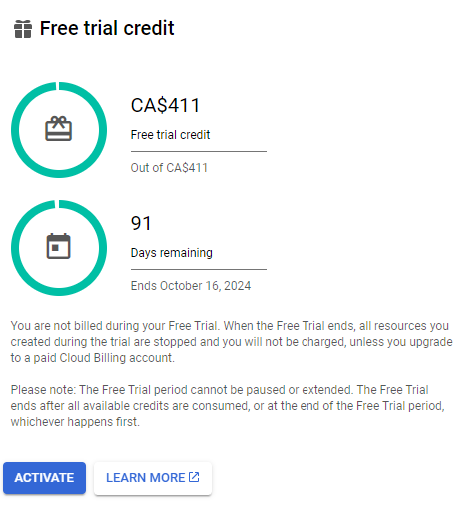

In "Billing", you can go to "Budgets & Alerts" on the left-hand side menu to set Limits and Warnings on your usage.

## Setting longer timeout

By default, Google Cloud will reset your webpage every 5 minutes, which can be annoying if you'd like to spend more time reading your result.

We can easily fix this:

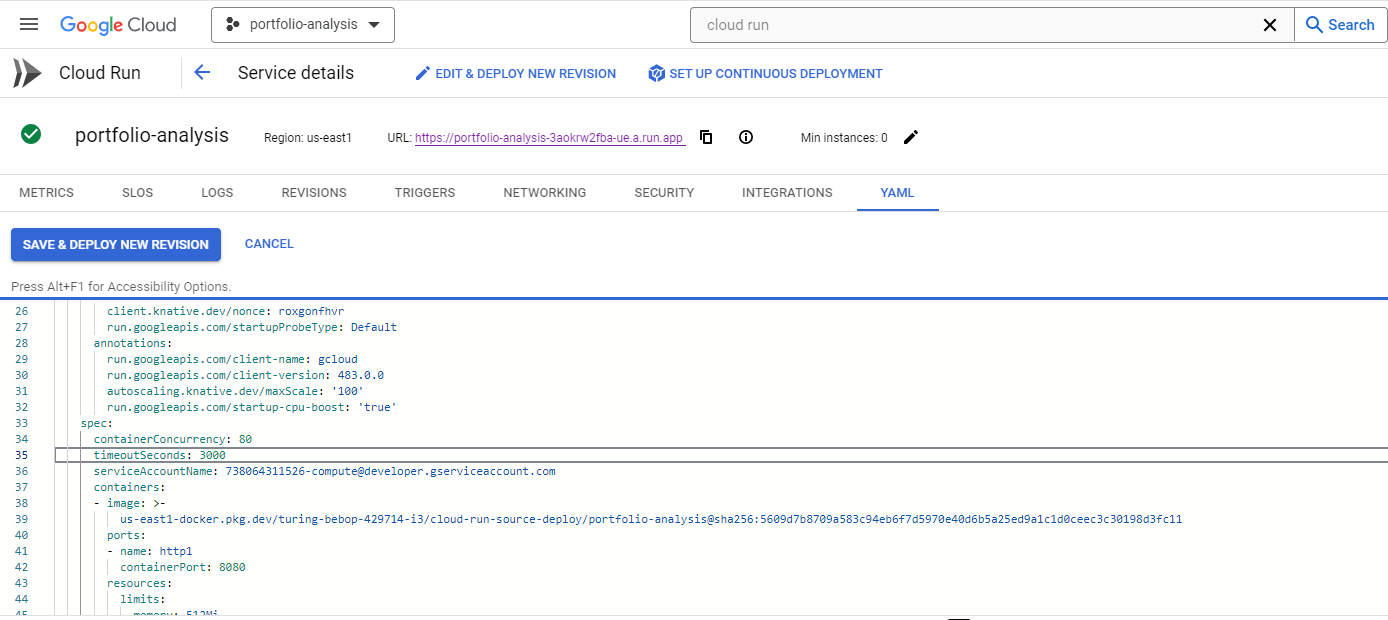